In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-6/Dataset_2/Mild Demented/mildDem412.jpg
/kaggle/input/dataset-6/Dataset_2/Mild Demented/mildDem257.jpg
/kaggle/input/dataset-6/Dataset_2/Mild Demented/mildDem276.jpg
/kaggle/input/dataset-6/Dataset_2/Mild Demented/mildDem682.jpg
/kaggle/input/dataset-6/Dataset_2/Mild Demented/mildDem376.jpg
/kaggle/input/dataset-6/Dataset_2/Mild Demented/mildDem100.jpg
/kaggle/input/dataset-6/Dataset_2/Mild Demented/mildDem176.jpg
/kaggle/input/dataset-6/Dataset_2/Mild Demented/28 (25).jpg
/kaggle/input/dataset-6/Dataset_2/Mild Demented/28 (28).jpg
/kaggle/input/dataset-6/Dataset_2/Mild Demented/mildDem97.jpg
/kaggle/input/dataset-6/Dataset_2/Mild Demented/mildDem46.jpg
/kaggle/input/dataset-6/Dataset_2/Mild Demented/mildDem29.jpg
/kaggle/input/dataset-6/Dataset_2/Mild Demented/mildDem537.jpg
/kaggle/input/dataset-6/Dataset_2/Mild Demented/mildDem306.jpg
/kaggle/input/dataset-6/Dataset_2/Mild Demented/mildDem343.jpg
/kaggle/input/dataset-6/Dataset_2/Mild Demented/mildDem688.jpg
/

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
from os import listdir
import pathlib
from random import randint
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils import load_img,img_to_array
from keras.models import Sequential
from keras.layers import MaxPooling2D,Dropout,Dense,Input,Conv2D,Flatten,Conv2DTranspose
from keras.layers import GlobalAveragePooling2D,MaxPool2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

2024-03-10 16:02:36.875809: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 16:02:36.875930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 16:02:37.023860: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
folder = '/kaggle/input/dataset-6/Dataset_2'
folder_path = pathlib.Path(folder)

In [5]:
for file in listdir(folder):
    print(file)

Mild Demented
Non Demented
Moderate Demented
VeryMild Demented


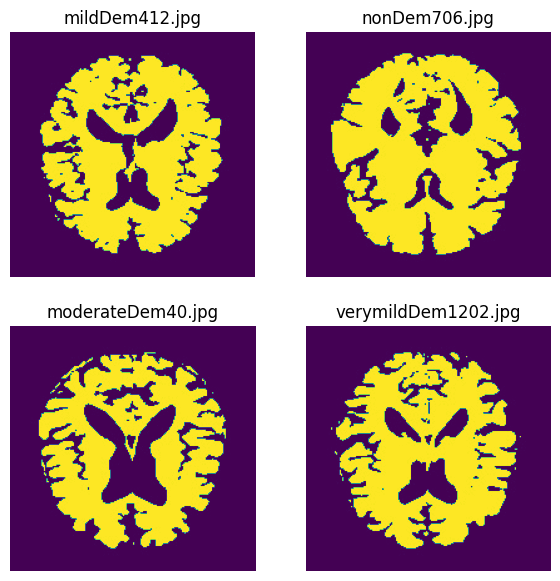

In [6]:
plt.figure(figsize=(7,7),)
j =0
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        if i ==1:
            break;
        img = imread(folder +'/' + file + '/' + image)
        ax = plt.subplot(2,2,j+1)
        plt.imshow(img)
        plt.title(image)
        plt.axis('off')
        j = j+1
        i = i +1
plt.show()

In [7]:
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        i = i +1
    print(file , i)

Mild Demented 896
Non Demented 3200
Moderate Demented 64
VeryMild Demented 2240


In [8]:
IMG_SIZE = 196
DIM = (IMG_SIZE, IMG_SIZE)

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

In [9]:
train_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


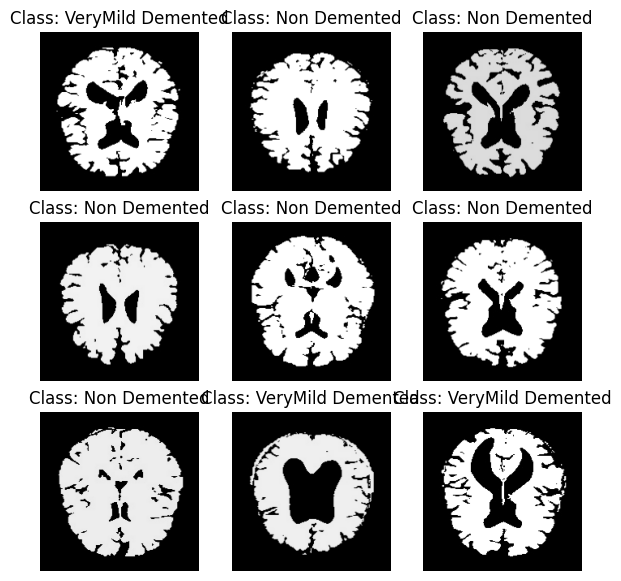

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint

CLASSES = list(train_data_gen.class_indices.keys())

def show_images(generator, y_pred=None):
    # get image labels
    labels = dict(zip([0, 1, 2, 3], CLASSES))
    # get a batch of images
    x, y = next(generator)
    
    # display a grid of 9 images
    plt.figure(figsize=(7, 7))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class: {}".format(labels[np.argmax(y[idx])]))                                                    
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual: {} \nPredicted: {}".format(labels[np.argmax(y[i])], labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)


In [11]:
train_data, train_labels = next(train_data_gen)

In [12]:
train_data.shape, train_labels.shape

((6400, 196, 196, 3), (6400, 4))

In [13]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

print(train_data.shape, train_labels.shape)

(12800, 115248) (12800, 4)


In [14]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(12800, 196, 196, 3) (12800, 4)


In [15]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [16]:
# Defining convolutional blocks
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [17]:
# defining dense blocks
def dense_block(units, dropout_rate, act='relu'):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [18]:
IMAGE_SIZE = [196,196]
act = 'relu'

In [19]:
model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

In [20]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]

model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 196, 196, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 196, 196, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 98, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 49, 49, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 24, 24, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 12, 12, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 6, 6, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 512)            │     4,721,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 128)            │        66,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,976,788 (22.80 MB)

 Trainable params: 5,974,420 (22.79 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [21]:
EPOCHS = 100

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/100


2024-03-10 16:07:55.540029: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.04432, expected 2.60192
2024-03-10 16:07:55.540103: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 195: 2.70697, expected 2.26457
2024-03-10 16:07:55.540115: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 391: 3.07306, expected 2.63066
2024-03-10 16:07:55.540129: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1567: 3.41108, expected 2.96868
2024-03-10 16:07:55.540143: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2940: 3.36517, expected 2.92277
2024-03-10 16:07:55.540156: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4115: 3.41143, expected 2.96904
2024-03-10 16:07:55.540165: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4311: 3.41752, expected 2.97512
2024-03-10 16:07:55.540176: E external/

  3/256 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - acc: 0.1632 - auc: 0.4252 - loss: 2.3278   

I0000 00:00:1710086890.170157     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


256/256 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - acc: 0.3240 - auc: 0.6012 - loss: 1.6946 - val_acc: 0.2568 - val_auc: 0.5069 - val_loss: 7.8408
Epoch 2/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - acc: 0.4963 - auc: 0.7760 - loss: 1.1170 - val_acc: 0.4097 - val_auc: 0.6731 - val_loss: 1.4934
Epoch 3/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - acc: 0.6311 - auc: 0.8839 - loss: 0.7921 - val_acc: 0.5181 - val_auc: 0.8241 - val_loss: 1.2518
Epoch 4/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - acc: 0.6569 - auc: 0.9031 - loss: 0.7158 - val_acc: 0.6611 - val_auc: 0.9063 - val_loss: 0.6982
Epoch 5/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - acc: 0.6872 - auc: 0.9181 - loss: 0.6570 - val_acc: 0.5547 - val_auc: 0.8371 - val_loss: 0.9857
Epoch 6/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - acc: 0.7152 - auc: 0.9284 - loss: 0.6181 - val_acc: 0.5337 - val_auc: 0.8309 - val_loss: 1.0201
Epoch 7/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - acc: 0.7297 - auc: 0.9377 - loss: 0.5

In [22]:
from sklearn.metrics import f1_score

# Assuming you have trained the model and obtained predictions
predictions = model.predict(test_data)

# Assuming predictions are in one-hot encoded format, you can convert them to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Assuming test_labels are in one-hot encoded format, you can convert them to class labels
true_labels = np.argmax(test_labels, axis=1)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("F1 Score:", f1)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
F1 Score: 0.9430829259841778


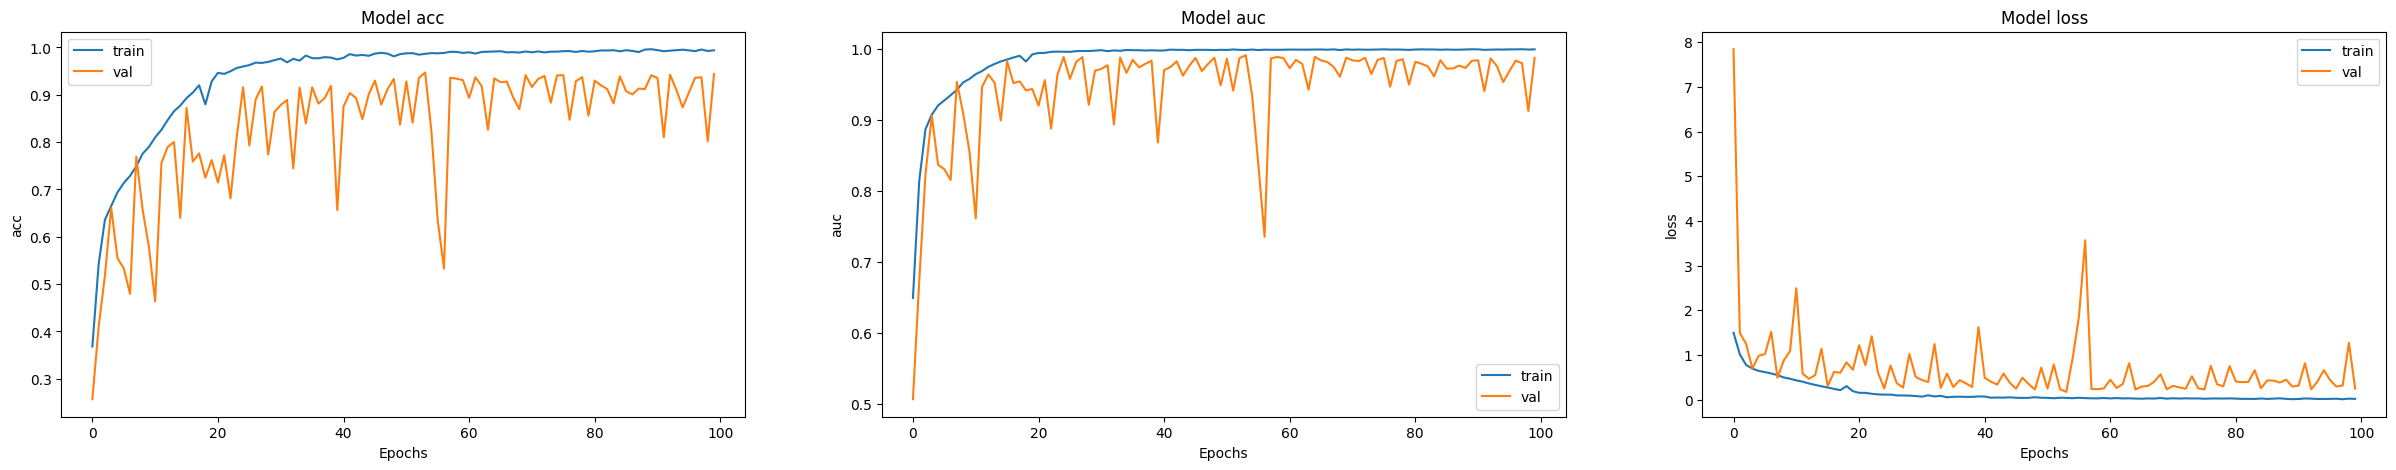

In [23]:

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [28]:
from sklearn.metrics import classification_report

class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented','VeryMild Demented']

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the report
print(report)


                   precision    recall  f1-score   support

    Mild Demented       0.95      0.98      0.97       639
Moderate Demented       1.00      1.00      1.00       635
     Non Demented       0.92      0.89      0.91       662
VeryMild Demented       0.91      0.90      0.90       624

         accuracy                           0.94      2560
        macro avg       0.94      0.94      0.94      2560
     weighted avg       0.94      0.94      0.94      2560



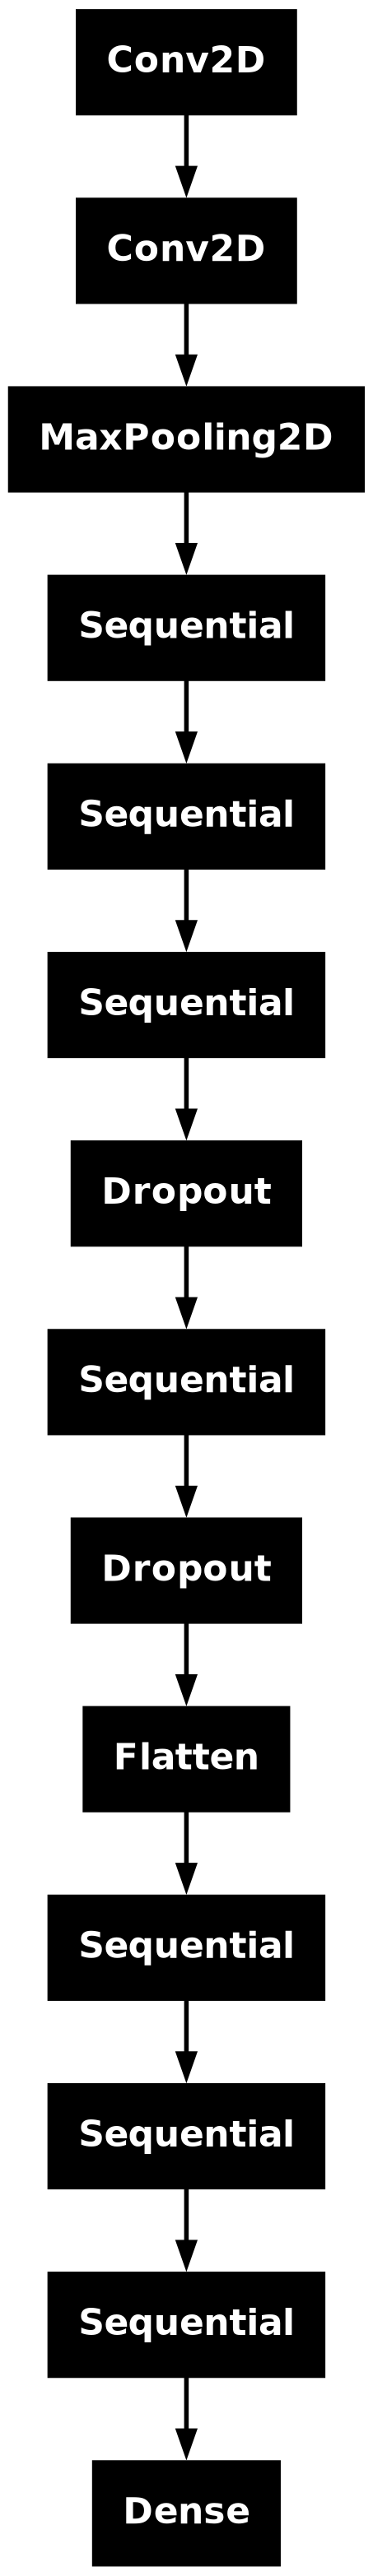

In [29]:
plot_model(model)

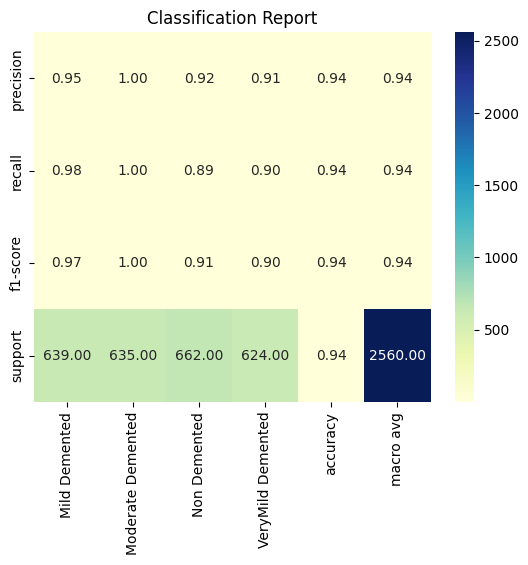

In [32]:
import seaborn as sns
from sklearn.metrics import classification_report

class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented','VeryMild Demented']

# Generate classification report
report_dict = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)

# Convert the classification report dictionary to a DataFrame for visualization
df = pd.DataFrame(report_dict).transpose()

# Plotting the DataFrame as a heatmap
sns.heatmap(df.iloc[:-1, :].T, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Classification Report')
plt.show()